In [107]:
import pandas as pd

In [108]:
# 读取Excel文件，跳过前44行，设置列名
df1 = pd.read_excel(
    '0702.xls',  
    skiprows=44,          # 跳过前44行说明
    header=None          # 无默认表头，后续手动设置
)

# 定义列名（对应A-F列）
df1.columns = [
    '年份',
    '能源消费总量（万吨标准煤）',
    '煤炭占比（%）',
    '石油占比（%）',
    '天然气占比（%）',
    '一次电力及其他能源占比（%）'
]

# 查看数据
print(df1.head())

     年份  能源消费总量（万吨标准煤）  煤炭占比（%）  石油占比（%）  天然气占比（%）  一次电力及其他能源占比（%）
0  2013          21909     77.2     12.9       4.8             5.2
1  2014          22890     77.7     12.6       4.5             5.3
2  2015          22343     76.4     13.3       5.2             5.1
3  2016          22323     75.4     14.3       5.2             5.0
4  2017          22162     71.6     14.6       5.8             8.0


![替代文字](p1.png "图片标题")
![替代文字](p2.png "图片标题")


In [109]:
df2 = pd.read_excel(
    'formula.xlsx',  
    skiprows=1,         
    header=None          # 无默认表头，后续手动设置
)

df2.columns = [
    '能源名称',
    '碳排放系数(kgCO2/kg或kgCO2/m3或kgCO₂/kWh)',
    '碳氧化率',
    '折标准煤系数(Kgce/Kg或Kgce/m3或Kgce/kWh)'
    
]

# 查看数据
print(df2.head())

        能源名称  碳排放系数(kgCO2/kg或kgCO2/m3或kgCO₂/kWh)  碳氧化率  \
0         煤炭                              1.9027  0.94   
1         石油                              3.0240  0.98   
2        天然气                              2.1649  0.99   
3  一次电力及其他能源                              1.0000  0.98   

  折标准煤系数(Kgce/Kg或Kgce/m3或Kgce/kWh)  
0                           0.7143  
1                           1.4286  
2                             1.33  
3                      ​​0.1229​​   


碳排放量可以用碳排放系数法计算：碳排放量=能源消费量×碳排放系数×碳氧化率× 44/12

In [110]:
# 标准煤折算系数（单位：kg标准煤/单位实物量）
standard_coal_factors = {
    '煤炭': 0.7143,     # kg标准煤/kg煤炭
    '石油': 1.4286,     # kg标准煤/kg石油
    '天然气': 1.33,      # kg标准煤/m³天然气
    # 一次电力不计算实物量转换
}

# 创建结果DataFrame
result_df = df1[['年份']].copy()
energy_types = ['煤炭', '石油', '天然气', '一次电力及其他能源']

for energy in energy_types:
    # 1. 计算各能源标准煤消费量（万吨标准煤）
    result_df[f'{energy}_消费量（万吨标准煤）'] = (
        df1['能源消费总量（万吨标准煤）'] * df1[f'{energy}占比（%）'] / 100
    )
    
    # 2. 处理一次电力（直接置零碳排放）
    if energy == '一次电力及其他能源':
        result_df[f'{energy}_碳排放量（万吨）'] = 0.0
        continue
    
    # 3. 标准煤转实物量（修正单位转换）
    factor = standard_coal_factors[energy]
    standard_coal = result_df[f'{energy}_消费量（万吨标准煤）']
    
    if energy == '天然气':
        # 天然气：万吨标准煤 → 亿立方米（正确逻辑）
        physical_amount = (standard_coal * 10000) / factor  # 转换为 m³（1万吨标准煤=10^7 kgce，factor单位为kgce/m³）
    else:
        # 煤炭/石油：万吨标准煤 → 万吨实物（去掉错误的*10000）
        physical_amount = standard_coal / factor  # 直接用万吨标准煤除以系数，得到万吨实物
    
    # 4. 获取碳排放参数
    coeff = df2[df2['能源名称'] == energy]['碳排放系数(kgCO2/kg或kgCO2/m3或kgCO₂/kWh)'].values[0]
    oxidation_rate = df2[df2['能源名称'] == energy]['碳氧化率'].values[0]
    
    # 5. 计算碳排放量（修正单位转换）
    if energy == '天然气':
        # 天然气：m³ → 万吨CO2（去掉错误的*100_000_000）
        result_df[f'{energy}_碳排放量（万吨）'] = (
            physical_amount  # m³
            * coeff          # kgCO2/m³
            * oxidation_rate 
            * (44/12)        # 碳→二氧化碳
            / 10_000        # kg→万吨（10^7 kg = 1万吨，这里physical_amount是m³，coeff是kg/m³，故总为kg，除以10^7）
        )
    else:
        # 煤炭/石油：万吨实物 → 万吨CO2（直接用万吨实物计算）
        result_df[f'{energy}_碳排放量（万吨）'] = (
            physical_amount  # 万吨实物
            * coeff          # kgCO2/kg实物 → 万吨实物 × 10^7 kg实物/万吨实物 × coeff kgCO2/kg实物 = 10^7 × 万吨实物 × coeff kgCO2
            * oxidation_rate 
            * (44/12) 
            / 10_000_000    # kgCO2→万吨CO2（除以10^7）
        )

# 汇总年度总碳排放量（忽略一次电力）
result_df['年度总碳排放量（万吨）'] = result_df[[
    f'{e}_碳排放量（万吨）' for e in energy_types if e != '一次电力及其他能源'
]].sum(axis=1)

# 结果保留年份和总排放量
final_df = result_df[['年份', '年度总碳排放量（万吨）']]
print(final_df)

     年份  年度总碳排放量（万吨）
0  2013  6213.808328
1  2014  6086.287349
2  2015  6864.972282
3  2016  6858.827171
4  2017  7595.051838
5  2018  7765.376520
6  2019  8037.637437
7  2020  7931.682719
8  2021  8887.097515
9  2022  9360.096297


In [111]:
# 划分训练集和测试集
train_data = result_df[result_df['年份'] <= 2020]['年度总碳排放量（万吨）'].values
test_data = result_df[result_df['年份'] > 2020][['年份', '年度总碳排放量（万吨）']].values
test_data
test_data_list = test_data[:, 1].tolist()
test_data_list

[8887.09751498092, 9360.096296949647]

In [112]:

# 灰色模型GM(1,1)实现
class GM11:
    def __init__(self):
        self.a = None
        self.b = None
        
    def fit(self, data):
        """训练模型"""
        n = len(data)
        if n < 4:
            raise ValueError("数据长度至少需要4个")
            
        # 累加生成序列(1-AGO)
        X1 = np.cumsum(data)
        
        # 紧邻均值生成序列
        Z1 = (X1[:-1] + X1[1:]) / 2.0
        
        # 构建矩阵B和Y
        B = np.vstack([-Z1, np.ones_like(Z1)]).T
        Y = data[1:].reshape(-1, 1)
        
        # 最小二乘法求解参数
        [[self.a], [self.b]] = np.linalg.inv(B.T @ B) @ B.T @ Y
        
        return self
    
    def predict(self, m):
        """预测未来m个值"""
        if self.a is None or self.b is None:
            raise Exception("模型尚未训练")
            
        n = len(self.history_data)
        X0_pred = np.zeros(n + m)
        X0_pred[0] = self.history_data[0]
        
        # 还原值
        for i in range(1, n + m):
            if i < n:
                # 训练数据的预测值
                X0_pred[i] = (1 - np.exp(self.a)) * (self.history_data[0] - self.b/self.a) * np.exp(-self.a * (i-1))
            else:
                # 未来预测值
                X0_pred[i] = (1 - np.exp(self.a)) * (self.history_data[0] - self.b/self.a) * np.exp(-self.a * (i-1))
                
        return X0_pred[n:]
    
    def summary(self):
        """模型概要"""
        if self.a is None or self.b is None:
            raise Exception("模型尚未训练")
            
        print(f"发展系数 a = {self.a:.6f}")
        print(f"灰作用量 b = {self.b:.6f}")
        print(f"GM(1,1)模型: X(k+1) = ({(self.history_data[0] - self.b/self.a):.6f})e^({-self.a:.6f}k) + ({self.b/self.a:.6f})")
        
        # 计算残差和相对误差
        n = len(self.history_data)
        X0_pred = np.zeros(n)
        X0_pred[0] = self.history_data[0]
        
        for i in range(1, n):
            X0_pred[i] = (1 - np.exp(self.a)) * (self.history_data[0] - self.b/self.a) * np.exp(-self.a * (i-1))
        
        residuals = self.history_data - X0_pred
        relative_errors = np.abs(residuals / self.history_data) * 100
        print(f"平均相对误差: {np.mean(relative_errors):.2f}%")
        print(f"精度: {100 - np.mean(relative_errors):.2f}%")
        
        return {
            'a': self.a,
            'b': self.b,
            'average_relative_error': np.mean(relative_errors),
            'accuracy': 100 - np.mean(relative_errors)
        }
    def calculate_errors(self, actual_values, predicted_values):
        """
        计算真实值与预测值之间的误差指标
        
        参数:
        actual_values (array-like): 真实值数组
        predicted_values (array-like): 预测值数组
        
        返回:
        dict: 包含各种误差指标的字典
        """
        if len(actual_values) != len(predicted_values):
            raise ValueError("真实值和预测值的长度必须相同")
        
        actual = np.array(actual_values)
        predicted = np.array(predicted_values)
        
        # 计算各种误差指标
        residuals = actual - predicted
        mae = np.mean(np.abs(residuals))                # 平均绝对误差
        mse = np.mean(residuals ** 2)                   # 均方误差
        rmse = np.sqrt(mse)                             # 均方根误差
        mape = np.mean(np.abs(residuals / actual)) * 100  # 平均绝对百分比误差（注意分母不能为0）
        
        # 计算精度（基于MAPE）
        accuracy = 100 - mape
        
        return {
            'mae': mae,
            'mse': mse,
            'rmse': rmse,
            'mape': mape,
            'accuracy': accuracy,
            'residuals': residuals
        }

In [113]:
# 训练模型
GM11_model = GM11()
GM11_model.history_data = train_data  # 保存历史数据
GM11_model.fit(train_data)

# 预测2021-2023年
pred_years = [i for i in range(2021,2023)]
GM11_pred_values = GM11_model.predict(len(pred_years))

# 输出预测结果
print("\nGM(1,1)预测结果:")
GM11_pred_df = pd.DataFrame({
    '年份': pred_years,
    '预测年度总碳排放量（万吨）': GM11_pred_values
})
print(GM11_pred_df)

# 模型概要
print("\n模型概要:")
GM11_model.summary()

res = GM11_model.calculate_errors(GM11_pred_values.tolist(),test_data_list)
res


GM(1,1)预测结果:
     年份  预测年度总碳排放量（万吨）
0  2021    8258.607595
1  2022    8613.179907

模型概要:
发展系数 a = -0.042038
灰作用量 b = 6022.355529
GM(1,1)模型: X(k+1) = (149475.054363)e^(0.042038k) + (-143261.246035)
平均相对误差: 3.76%
精度: 96.24%


{'mae': 687.7031550386491,
 'mse': 476441.836680245,
 'rmse': 690.2476632921296,
 'mape': 8.140952020268385,
 'accuracy': 91.85904797973161,
 'residuals': array([-628.48991978, -746.9163903 ])}

GM11_pred_values [8258.6075952  8613.17990665]


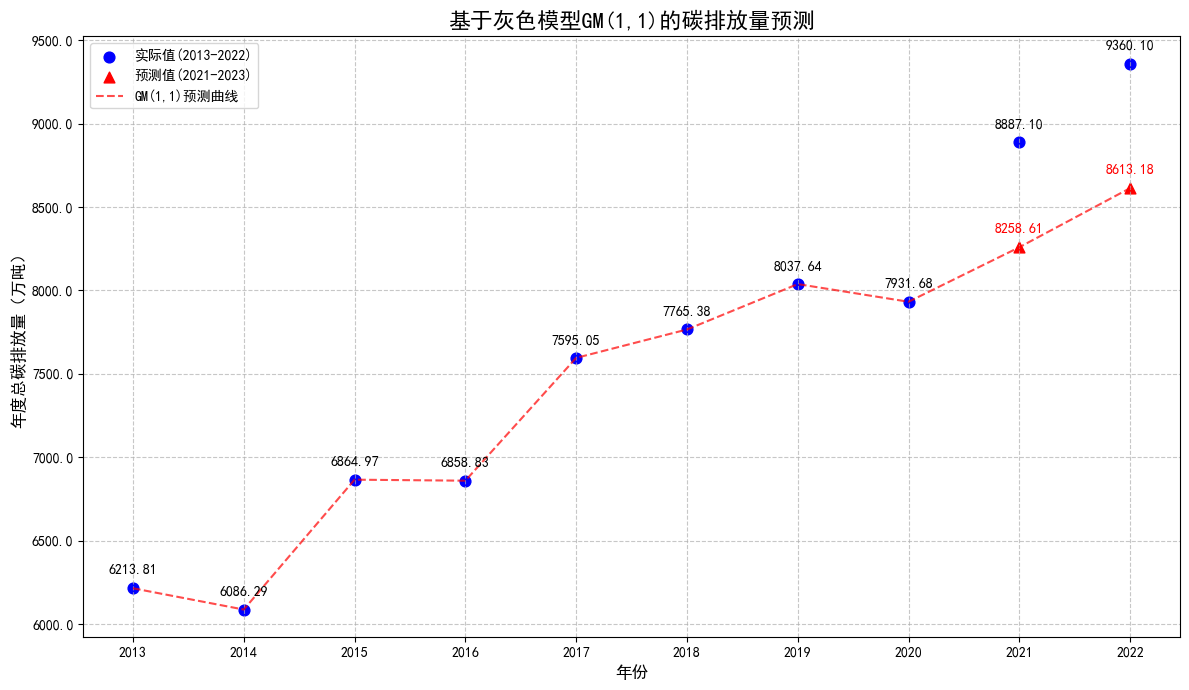

In [114]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


# 设置中文字体
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
# 可视化
plt.figure(figsize=(12, 7))

# 原始数据
plt.scatter(result_df['年份'], result_df['年度总碳排放量（万吨）'], 
            color='blue', label='实际值(2013-2022)', s=60)

# 预测数据
plt.scatter(pred_years[:3], GM11_pred_values[:3], color='red', 
            label='预测值(2021-2023)', s=60, marker='^')
# plt.scatter(pred_years[2], pred_values[2], color='green', 
#             label='预测值(2023)', s=60, marker='*')

# 绘制预测曲线
all_years = list(range(2013, 2023))
train_years = list(range(2013, 2021))
all_pred_values = np.concatenate([train_data, GM11_pred_values])
plt.plot(all_years, all_pred_values, 'r--', alpha=0.7, 
         label='GM(1,1)预测曲线')

# 添加数据标签
for x, y in zip(result_df['年份'], result_df['年度总碳排放量（万吨）']):
    plt.annotate(f'{y:.2f}', (x, y), textcoords='offset points',
                 xytext=(0,10), ha='center', rotation=0)
print('GM11_pred_values',GM11_pred_values)
for x, y in zip(pred_years, GM11_pred_values):
    plt.annotate(f'{y:.2f}', (x, y), textcoords='offset points',
                 xytext=(0,10), ha='center', rotation=0, color='red' if x <= 2023 else 'green')

# 设置图表格式
plt.title('基于灰色模型GM(1,1)的碳排放量预测', fontsize=16)
plt.xlabel('年份', fontsize=12)
plt.ylabel('年度总碳排放量（万吨）', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(all_years)
plt.legend(loc='upper left', fontsize=10)

# 设置y轴格式化
def format_number(value, tick_number):
    if value >= 1e8:
        return f'{value/1e8:.1f}亿'
    elif value >= 1e4:
        return f'{value/1e4:.1f}万'
    return f'{value:.1f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_number))

plt.tight_layout()
plt.savefig('carbon_emission_prediction.png', dpi=300, bbox_inches='tight')
plt.show()   

本项目选择使用粒子群优化算法，来计算最优系数α，
相对均值加权标准差(RRWSE)
建立FGMW(1,1,λ,n)模型

In [129]:
import numpy as np
import scipy.special as sp
from scipy.optimize import minimize

class MFGMW11(GM11):
    def __init__(self, alpha_range=(0.01, 2.0), reoptimize_alpha=True):
        """
        初始化MFGMW(1,1)模型
        :param alpha_range: 累加阶数α的搜索范围
        :param reoptimize_alpha: 预测时是否重新优化α
        """
        self.alpha_range = alpha_range
        self.reoptimize_alpha = reoptimize_alpha
        self.history_data = None
        self.n = None
        self.alpha = None
        self.a = None
        self.b = None
        self.D = None
    
    def fit(self, train_data):
        """
        拟合模型参数（使用RRWSE最小化确定最优α）
        :param train_data: 一维时间序列数据(np.array)
        """
        self.history_data = train_data
        self.n = len(train_data)
        
        # 使用优化方法寻找最优α
        def objective(alpha):
            _, _, _, rrwse, _ = self._build_model(train_data, alpha)
            return rrwse
        
        res = minimize(objective, x0=1.0, bounds=[self.alpha_range])
        self.alpha = res.x[0]
        
        # 使用最优α重建模型
        self.a, self.b, self.D, _, _ = self._build_model(train_data, self.alpha)
        return self
    
    def predict(self, steps):
        """
        预测未来值（使用新陈代谢思想）
        :param steps: 预测步数
        :return: 预测值数组(np.array)
        """
        if self.history_data is None or self.a is None:
            raise Exception("Model not fitted. Call fit() first.")
        
        predictions = []
        current_data = self.history_data.copy()
        
        for _ in range(steps):
            # 根据流程图要求，每次预测都重新优化α
            if self.reoptimize_alpha:
                # 优化当前窗口的最优α
                def objective(alpha):
                    _, _, _, rrwse, _ = self._build_model(current_data, alpha)
                    return rrwse
                res = minimize(objective, x0=self.alpha, bounds=[self.alpha_range])
                alpha_temp = res.x[0]
            else:
                alpha_temp = self.alpha
                
            # 使用当前数据和α拟合临时模型
            a_temp, b_temp, D_temp, _, _ = self._build_model(current_data, alpha_temp)
            
            # 预测下一步
            next_val = self._predict_step(current_data, a_temp, b_temp, D_temp)
            predictions.append(next_val)
            
            # 新陈代谢：添加新预测值，移除最旧的数据
            current_data = np.append(current_data[1:], next_val)
            
        return np.array(predictions)
    
    def _build_model(self, data, alpha):
        """
        根据给定数据和α构建FGMW(1,1)模型
        :param data: 输入数据
        :param alpha: 累加阶数
        :return: (a, b, D, rrwse, x_alpha_fit)
        """
        n = len(data)
        
        # 1. 计算α阶累加序列 (α-AGO)
        x_alpha = self._fractional_accumulate(data, alpha)
        
        # 2. 计算背景值序列（紧邻均值生成序列）
        z_alpha = self._background_value(x_alpha)  # 长度n-1
        
        # 3. 构建矩阵B和Y（公式2-33）
        # Y = [x_alpha(2)-x_alpha(1), ..., x_alpha(n)-x_alpha(n-1)]
        Y = np.array([x_alpha[k] - x_alpha[k-1] for k in range(1, n)]).reshape(-1, 1)
        
        # B = [[-z_alpha(1), 1], ..., [-z_alpha(n-1), 1]]
        B = np.column_stack([-z_alpha, np.ones(n-1)])
        
        # 4. 构建权重向量Z（公式2-38）
        Z = np.arange(2, n+1).reshape(-1, 1)  # k从2到n
        
        # 5. 计算加权最小二乘参数（公式2-39）
        # 加权设计矩阵 = Z.*B
        B_weighted = B * Z
        
        # 参数估计：ξ = ((Z.*B)ᵀB)⁻¹(Z.*B)ᵀY
        try:
            xi = np.linalg.inv(B_weighted.T @ B) @ (B_weighted.T @ Y)
        except np.linalg.LinAlgError:
            # 处理奇异矩阵
            xi = np.linalg.pinv(B_weighted.T @ B) @ (B_weighted.T @ Y)
            
        a, b = xi.flatten()
        
        # 6. 计算参数D（公式2-27）
        k_values = np.arange(1, n+1)
        numerator = np.sum(k_values * (x_alpha - b/a) * np.exp(-a*k_values))
        denominator = np.sum(k_values * np.exp(-2*a*k_values))
        D = numerator / denominator
        
        # 7. 计算累加序列拟合值（公式2-28）
        k_values = np.arange(1, n+1)
        x_alpha_fit = D * np.exp(-a * k_values) + b / a
        
        # 8. 累减还原原始序列（公式2-16）
        x0_fit = self._fractional_reduce(x_alpha_fit, alpha)
        
        # 9. 计算RRWSE（公式2-41）
        rrwse = self._calc_rrwse(data, x0_fit)
        
        return a, b, D, rrwse, x_alpha_fit
    
    def _predict_step(self, data, a, b, D):
        """
        使用当前模型预测下一个值（新陈代谢）
        """
        n = len(data)
        # 计算当前数据的累加序列
        x_alpha = self._fractional_accumulate(data, self.alpha)
        
        # 计算下一个时间点的累加值
        x_alpha_next = D * np.exp(-a * (n + 1)) + b / a
        
        # 构建扩展的累加序列用于还原
        x_alpha_extended = np.append(x_alpha, x_alpha_next)
        
        # 只还原最新点 (k = n+1)
        x0_next = self._fractional_reduce_point(x_alpha_extended, self.alpha, k=n+1)
        
        return x0_next
    
    def _fractional_accumulate(self, x0, alpha):
        """
        计算分数阶累加序列 (α-AGO) (公式2-11)
        使用伽玛函数计算二项式系数以提高数值稳定性
        """
        n = len(x0)
        x_alpha = np.zeros(n)
        
        # 预计算对数伽玛值
        ln_gamma_alpha = sp.gammaln(alpha)
        
        for k in range(n):
            s = 0.0
            for i in range(k+1):
                # 计算分数阶二项式系数 (使用对数避免数值溢出)
                ln_coef = (
                    sp.gammaln(alpha + k - i + 1) 
                    - sp.gammaln(k - i + 1) 
                    - sp.gammaln(alpha) 
                    - sp.gammaln(i+1)
                )
                coef = np.exp(ln_coef)
                s += coef * x0[i]
            x_alpha[k] = s
        
        return x_alpha
    
    def _background_value(self, x_alpha):
        """
        计算背景值序列 (紧邻均值生成序列) (公式2-12)
        """
        n = len(x_alpha)
        # 背景值序列长度 = n-1
        return np.array([(x_alpha[k] + x_alpha[k-1]) / 2.0 for k in range(1, n)])
    
    def _fractional_reduce(self, x_alpha, alpha):
        """
        累减还原原始序列 (公式2-16)
        使用伽玛函数计算二项式系数以提高数值稳定性
        """
        n = len(x_alpha)
        x0_hat = np.zeros(n)
        
        # 预计算对数伽玛值
        ln_gamma_alpha_plus1 = sp.gammaln(alpha + 1)
        
        for k in range(n):
            s = 0.0
            for i in range(k+1):  # i从0到k
                # 计算二项式系数 (使用对数避免数值溢出)
                ln_binom = (
                    ln_gamma_alpha_plus1 
                    - sp.gammaln(i+1) 
                    - sp.gammaln(alpha - i + 1)
                )
                binom = np.exp(ln_binom)
                coef = (-1)**i * binom
                # 累加序列中的位置 (k-i)
                idx = k - i
                s += coef * x_alpha[idx]
            x0_hat[k] = s
        
        return x0_hat
    
    def _fractional_reduce_point(self, x_alpha, alpha, k):
        """
        还原特定点(k)的值 (公式2-16)
        k: 要还原的点（从1开始计数）
        """
        s = 0.0
        # 预计算对数伽玛值
        ln_gamma_alpha_plus1 = sp.gammaln(alpha + 1)
        
        for i in range(k):  # i从0到k-1
            # 计算二项式系数 (使用对数避免数值溢出)
            ln_binom = (
                ln_gamma_alpha_plus1 
                - sp.gammaln(i+1) 
                - sp.gammaln(alpha - i + 1)
            )
            binom = np.exp(ln_binom)
            coef = (-1)**i * binom
            # 累加序列中的位置 (k-i-1 因为k从1计数，索引从0)
            s += coef * x_alpha[k - i - 1]
        return s
    
    def _calc_rrwse(self, x0_true, x0_pred):
        """
        计算相对加权标准差 (RRWSE) (公式2-41)
        """
        n = len(x0_true)
        total_weight = n * (n + 1) / 2  # 1+2+...+n
        
        # 计算加权平方和 (WSE)
        wse = 0.0
        for k in range(n):
            # 权重为(k+1) 因为k从0开始，对应第1到第n个数据点
            weight = (k + 1) / total_weight
            error = x0_true[k] - x0_pred[k]
            wse += weight * (error ** 2)
        
        # 计算相对加权标准差 (RRWSE)
        mean_x0 = np.mean(x0_true)
        rrwse = (np.sqrt(wse) / mean_x0) * 100  # 百分比形式
        
        return rrwse

In [132]:
# 训练模型
MFGMW11_model = MFGMW11()
MFGMW11_model.history_data = train_data  # 保存历史数据
MFGMW11_model.fit(train_data)

# 预测2021-2022年
pred_years = [i for i in range(2021,2023)]
MFGMW11_pred_values = MFGMW11_model.predict(len(pred_years))

# 输出预测结果
print("\n预测结果:")
pred_df = pd.DataFrame({
    '年份': pred_years,
    '预测年度总碳排放量（万吨）': MFGMW11_pred_values
})
print(pred_df)
print(test_data)
# 模型概要
print("\n模型概要:")
MFGMW11_model.summary()

res = MFGMW11_model.calculate_errors(MFGMW11_pred_values.tolist(),test_data_list)
res


预测结果:
     年份  预测年度总碳排放量（万吨）
0  2021    8867.051991
1  2022    9366.963032
[[2021.         8887.09751498]
 [2022.         9360.09629695]]

模型概要:
发展系数 a = 0.273057
灰作用量 b = 3538.776030
GM(1,1)模型: X(k+1) = (-6746.040833)e^(-0.273057k) + (12959.849161)
平均相对误差: 73.81%
精度: 26.19%


{'mae': 13.456129267631695,
 'mse': 224.48753113514536,
 'rmse': 14.982907966584635,
 'mape': 0.14968776364497136,
 'accuracy': 99.85031223635502,
 'residuals': array([-20.04552349,   6.86673504])}

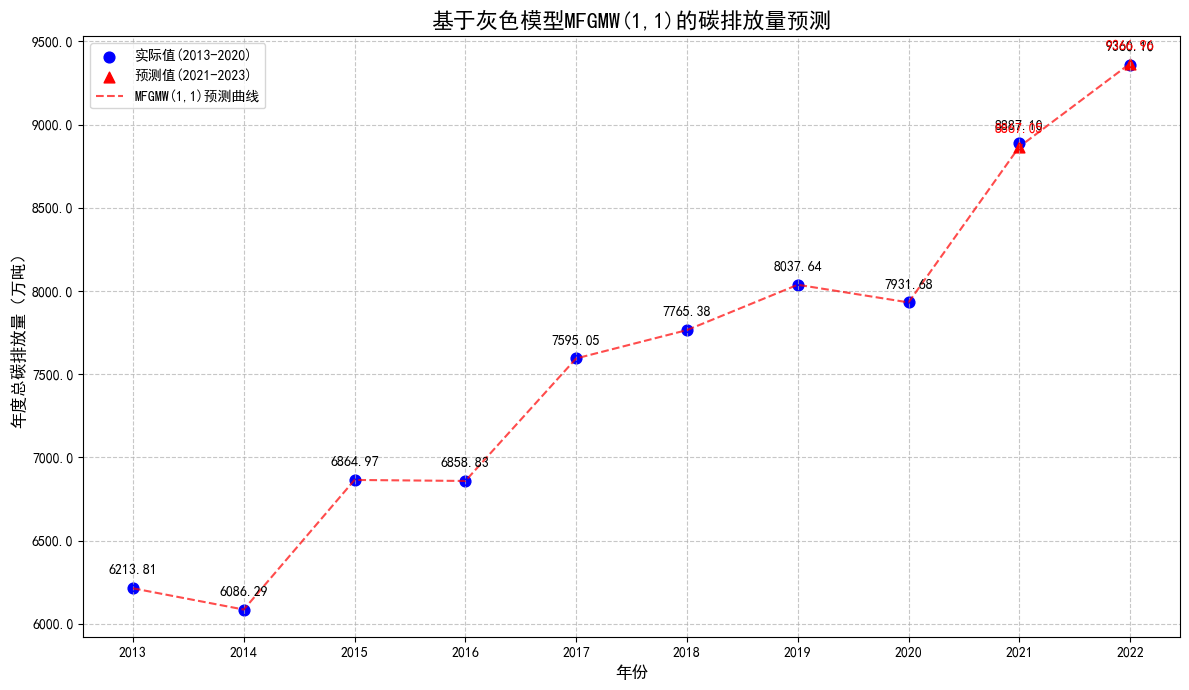

In [134]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


# 设置中文字体
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
# 可视化
plt.figure(figsize=(12, 7))

# 原始数据
plt.scatter(result_df['年份'], result_df['年度总碳排放量（万吨）'], 
            color='blue', label='实际值(2013-2020)', s=60)

# 预测数据
plt.scatter(pred_years[:3], MFGMW11_pred_values[:3], color='red', 
            label='预测值(2021-2023)', s=60, marker='^')
# plt.scatter(pred_years[2], pred_values[2], color='green', 
#             label='预测值(2023)', s=60, marker='*')

# 绘制预测曲线
all_years = list(range(2013, 2023))
train_years = list(range(2013, 2021))
all_pred_values = np.concatenate([train_data, MFGMW11_pred_values])
plt.plot(all_years, all_pred_values, 'r--', alpha=0.7, 
         label='MFGMW(1,1)预测曲线')

# 添加数据标签
for x, y in zip(result_df['年份'], result_df['年度总碳排放量（万吨）']):
    plt.annotate(f'{y:.2f}', (x, y), textcoords='offset points',
                 xytext=(0,10), ha='center', rotation=0)
    
for x, y in zip(pred_years, MFGMW11_pred_values):
    plt.annotate(f'{y:.2f}', (x, y), textcoords='offset points',
                 xytext=(0,10), ha='center', rotation=0, color='red' if x <= 2023 else 'green')

# 设置图表格式
plt.title('基于灰色模型MFGMW(1,1)的碳排放量预测', fontsize=16)
plt.xlabel('年份', fontsize=12)
plt.ylabel('年度总碳排放量（万吨）', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(all_years)
plt.legend(loc='upper left', fontsize=10)

# 设置y轴格式化
def format_number(value, tick_number):
    if value >= 1e8:
        return f'{value/1e8:.1f}亿'
    elif value >= 1e4:
        return f'{value/1e4:.1f}万'
    return f'{value:.1f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_number))

plt.tight_layout()
plt.savefig('MFGMW11_carbon_emission_prediction.png', dpi=300, bbox_inches='tight')
plt.show()   

碳排放量可以用碳排放系数法计算：碳排放量=能源消费量×碳排放系数×碳氧化率× 44/12